In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

%cd /content/drive/MyDrive

/content/drive/MyDrive


In [7]:

import zipfile
import os
zip_file_path = '/content/drive/MyDrive/archive.zip'
extracted_folder = '/content/sample_data'
os.makedirs(extracted_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("Extraction complete.")


Extraction complete.


In [8]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [9]:

dir = '/content/sample_data/Training'

In [10]:


Genders = os.listdir(dir)

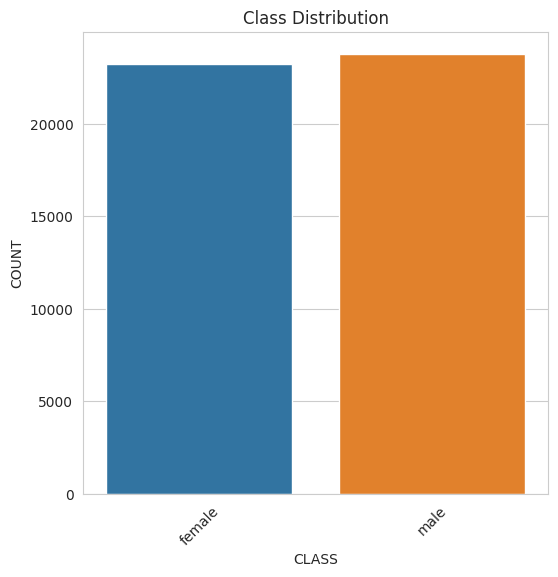

In [34]:
class_counts = [len(os.listdir(os.path.join(dir, Gender))) for Gender in Genders] #Used List Comprehension

sns.set_style('whitegrid')
plt.figure(figsize=(6, 6))
sns.barplot(x=Genders, y=class_counts)
plt.xlabel('CLASS')
plt.ylabel('COUNT')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

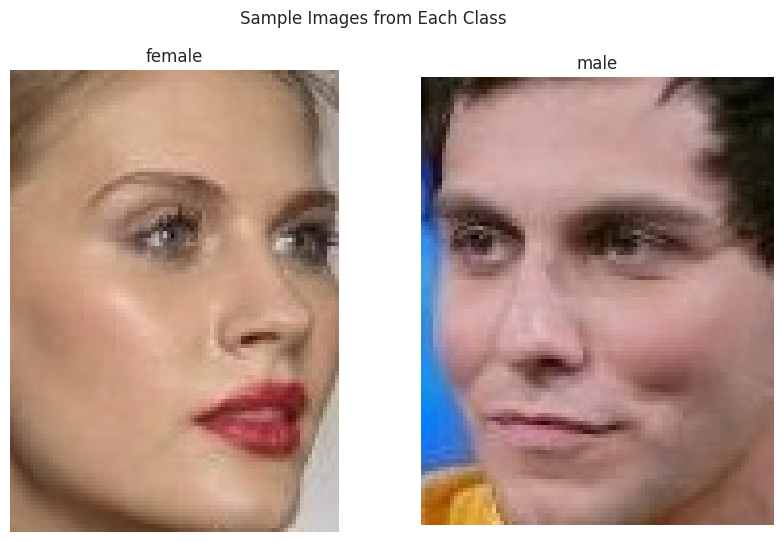

In [13]:

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(Genders):
    class_path = os.path.join(dir, class_name)
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    image = Image.open(image_path)

    plt.subplot(1, len(Genders), i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

In [14]:

import os
total_images = sum([len(os.listdir(os.path.join(dir, Gender))) for Gender in Genders])
expected_images_per_class = total_images / len(Genders)


In [18]:

missing_values = []
for Gender in Genders:
    class_path = os.path.join(dir, class_name)
    num_images = len(os.listdir(class_path))
    missing_images = expected_images_per_class - num_images
    missing_values.append({'Class': class_name, 'Missing': missing_images})


print("Missing Values:")
for entry in missing_values:
    print(f"Class: {entry['Class']}, Missing: {entry['Missing']}")

Missing Values:
Class: male, Missing: -261.5
Class: male, Missing: -261.5


In [19]:
import os
import numpy as np
import tensorflow as tf
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [20]:
img_width, img_height =32,32
batch_size = 16
epochs = 8

In [21]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Load and preprocess all images
all_data_generator = datagen.flow_from_directory(
    dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Split data into training and testing sets
X_all = np.concatenate([all_data_generator.next()[0] for _ in range(len(all_data_generator))])
y_all = all_data_generator.classes
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Load a pre-trained CNN model for feature extraction
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

Found 47009 images belonging to 2 classes.
58889256/58889256 [==============================] - 1s 0us/step


In [22]:

features_train = base_model.predict(X_train, verbose=1)
features_test = base_model.predict(X_test, verbose=1)

294/294 [==============================] - 130s 442ms/step


In [23]:

flattened_features_train = features_train.reshape(features_train.shape[0], -1)
flattened_features_test = features_test.reshape(features_test.shape[0], -1)

In [24]:

svm_model = LinearSVC()
svm_model.fit(flattened_features_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [25]:
predictions_train = svm_model.predict(flattened_features_train)
predictions_test = svm_model.predict(flattened_features_test)

In [26]:
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)
print(f'Training Accuracy: {accuracy_train:.2f}')
print(f'Test Accuracy: {accuracy_test:.2f}')

Training Accuracy: 0.78
Test Accuracy: 0.78


In [27]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam

In [30]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Load and preprocess all images
all_data_generator = datagen.flow_from_directory(
    dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 47009 images belonging to 2 classes.


In [29]:
X_all = np.concatenate([all_data_generator.next()[0] for _ in range(len(all_data_generator))])
y_all = all_data_generator.classes
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [31]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),

    Dense(1, activation='sigmoid')
])


In [32]:
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

Epoch 1/8
2351/2351 [==============================] - 92s 39ms/step - loss: 0.4225 - accuracy: 0.7944 - val_loss: 0.2705 - val_accuracy: 0.8919
Epoch 2/8
2351/2351 [==============================] - 88s 37ms/step - loss: 0.2401 - accuracy: 0.9062 - val_loss: 0.2228 - val_accuracy: 0.9160
Epoch 3/8
2351/2351 [==============================] - 84s 36ms/step - loss: 0.2056 - accuracy: 0.9209 - val_loss: 0.2198 - val_accuracy: 0.9129
Epoch 4/8
2351/2351 [==============================] - 93s 40ms/step - loss: 0.1862 - accuracy: 0.9279 - val_loss: 0.2107 - val_accuracy: 0.9251
Epoch 5/8
2351/2351 [==============================] - 93s 39ms/step - loss: 0.1722 - accuracy: 0.9355 - val_loss: 0.1980 - val_accuracy: 0.9250
Epoch 6/8
2351/2351 [==============================] - 89s 38ms/step - loss: 0.1590 - accuracy: 0.9398 - val_loss: 0.2121 - val_accuracy: 0.9203
Epoch 7/8
2351/2351 [==============================] - 93s 40ms/step - loss: 0.1482 - accuracy: 0.9447 - val_loss: 0.1965 - val_ac

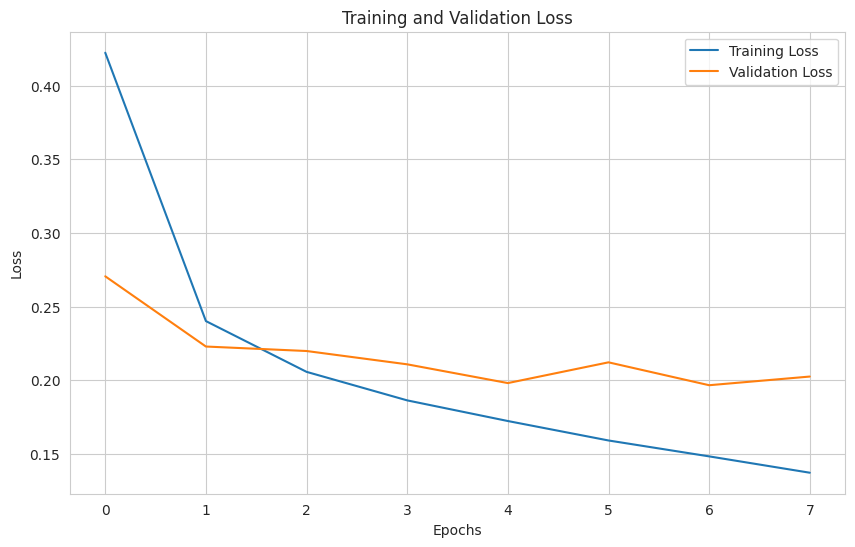

In [35]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

